<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Intro to PyTorch

## Deliverable

For this lab, you will submit an ipython notebook via learningsuite.
This lab will be mostly boilerplate code, but you will be required to implement a few extras.

**NOTE: you almost certainly will not understand most of what's going on in this lab!
That's ok - the point is just to get you going with pytorch.
We'll be working on developing a deeper understanding of every part of this code
over the course of the next two weeks.**

A major goal of this lab is to help you become conversant in working through pytorch
tutorials and documentation.
So, you should feel free to google whatever you want and need!

This notebook will have four parts:

* Part 1: Your notebook should contain the boilerplate code. See below.

* Part 2: Your notebook should extend the boilerplate code by adding a testing loop.

* Part 3: Your notebook should extend the boilerplate code by adding a visualization of test/training performance over time.

The resulting image could, for example, look like this:
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?cache=&w=900&h=608&tok=3092fe&media=cs501r_f2018:lab2.png)

* Part 4: Your notebook should contain the completed microtasks and pass all the asserts.

See the assigned readings for pointers to documentation on pytorch.
___

### Grading standards:
Your notebook will be graded on the following:

* 40% Successfully followed lab video and typed in code
* 20% Modified code to include a test/train split
* 20% Modified code to include a visualization of train/test losses
* 10% Tidy and legible figures, including labeled axes where appropriate
* 10% Correct solutions to the microtasks
___

### Description
Throughout this class, we will be using pytorch to implement our deep neural networks. 
Pytorch is a deep learning framework that handles the low-level details of 
GPU integration and automatic differentiation.

The goal of this lab is to help you become familiar with pytorch. 
The four parts of the lab are outlined above.

For part 1, you should watch the video below, and type in the code as it is explained to you.

A more detailed outline of Part 1 is below.

For part 2, you must add a validation (or testing) loop using the 
FashionMNIST dataset with train=False

For part 3, you must plot the loss values.

For part 4, you must complete the microtasks and pass all asserts.

Optional: Demonstrate overfitting on the training data.

The easiest way to do this is to limit the size of your training dataset 
so that it only returns a single batch (ie len(dataloader) == batch_size, 
and train for multiple epochs. For example,
I set my batch size to 42, and augmented my dataloader to produce only 42 
unique items by overwriting the len function to return 42. 
In my training loop, I performed a validation every epoch which basically corresponded 
to a validation every step.

In practice, you will normally compute your validation loss every n steps, 
rather than at the end of every epoch. This is because some epochs can take hours, 
or even days and you don’t often want to wait that long to see your results.

Testing your algorithm by using a single batch and training until overfitting 
is a great way of making sure that your model and optimizer are working the way they should!

___

### Part 0
Watch Tutorial Video

[https://youtu.be/E76hLX9WCLE](https://youtu.be/E76hLX9WCLE)

**TODO:**

**DONE:**
* Watch video

___

### Part 1
Your notebook should contain the boilerplate code. See below.

**TODO:**

**DONE:**
* Replicate boilerplate from the video

___

### Part 2
Your notebook should extend the boilerplate code by adding a testing loop.

**TODO:**

**DONE:**
* Add a testing (validation) loop

In [ ]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
 
# You need to request a GPU from Runtime > Change Runtime Type
assert torch.cuda.is_available() 

In [ ]:
# REQUIREMENT: Extend the torch.Module class to create your own neural network
class LinearNetwork(nn.Module):
  def __init__(self, dataset):
    super(LinearNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    out_dim = 10 # <- Would use y, but y is a number between 0 and 9

    self.net = nn.Sequential(
        nn.Linear(c * h * w, 1000), # (input size, output size)
        nn.ReLU(),
        nn.Linear(1000, out_dim),
    )

  def forward(self, x):
    n, c, h, w = x.size()

    # Smash dimensions together, except for the batch size
    flattened = x.view(n, c * h * w) 

    return self.net(flattened)

  # Don't override this, mathmeticians are smart did a good job.
  # def backward(self)

In [ ]:
# REQUIREMENT: Create a dataset class that extends the torch.utils.data Dataset class here
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(
        root,
        train=train,
        transform=transforms.ToTensor(),
        download=True # Cache the dataset
    )

  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y

  def __len__(self):
    return len(self.data)

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 42
BATCH_VALIDATION_SIZE = 10
LR = 1e-4

# REQUIREMENT: Instantiate the train and validation sets
dataset_train = FashionMNISTProcessedDataset(
    '/tmp/fashionmnist', 
    train = True
)

dataset_val = FashionMNISTProcessedDataset(
    '/tmp/fashionmnist', 
    train = False
)

# REQUIREMENT: Instantiate your data loaders
loader_train = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE, 
    pin_memory=True
)

loader_val = DataLoader(
    dataset_val, 
    batch_size=BATCH_SIZE, 
)

# REQUIREMENT: Instantiate your model and loss and optimizer functions
model = LinearNetwork(dataset_train)
model = model.cuda()
optimizer = optim.SGD(model.parameters(), lr=LR)
objective = torch.nn.CrossEntropyLoss()

loop = tqdm(total=len(loader_train) * NUM_EPOCHS, position=0)
losses_counter = 0
losses_train = []
losses_val = []

# REQUIREMENT: Run your training / validation loops
for epoch in range(NUM_EPOCHS):
  # Only validate on the first batch
  batch = 0

  # Run training loop
  for x, y_truth in loader_train:
    # Place the variables on the GPU
    x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

    # Zero out the gradient
    optimizer.zero_grad()

    # Get the prediction
    y_hat = model(x)

    # Compute the loss
    loss = objective(y_hat, y_truth)

    # Track loss and only validate on the first batch
    if epoch % BATCH_VALIDATION_SIZE == 0 and batch == 0:
      # Compute the validation loss
      tmp_val_losses = []
      for val_x, val_y_truth in loader_val:
        val_x, val_y_truth = val_x.cuda(non_blocking=True), val_y_truth.cuda(non_blocking=True)
        val_y_hat = model(val_x)
        val_loss = objective(val_y_hat, val_y_truth)
        tmp_val_losses.append(val_loss)

      # Store the loss
      losses_val.append((sum(tmp_val_losses) / len(tmp_val_losses)).item())
      losses_train.append(loss.item())
      losses_counter += 1

    # Track progress
    loop.set_description('epoch={}, batch={}, loss={:.4f}, val_loss={:.4f}'.format(
        epoch, batch, losses_train[-1], losses_val[-1]))

    # Compute the gradient from backprop and step the optimizer
    loss.backward()
    optimizer.step()
    batch += 1

epoch=99, batch=1428, loss=0.6084, val_loss=0.6589:   0%|          | 0/142900 [14:28<?, ?it/s]


___

### Part 3
Your notebook should extend the boilerplate code by adding a visualization of test/training
performance over time. Use matplotlib.pyplot

**TODO:**

**DONE:**
* Add a visualization of test/train performance (i.e. loss) over time.


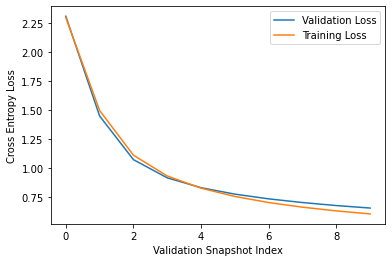

In [ ]:
# Write your code to create a plot of your loss over time
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(losses_val)), losses_val, label='Validation Loss')
ax.plot(range(len(losses_train)), losses_train, label='Training Loss')
plt.xlabel("Validation Snapshot Index")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()


___

### Part 4
Complete the following microtasks to learn some important Pytorch skills. 

**TODO:**

**DONE:**
* Complete microtasks

In [ ]:
# Tensors are the the lifeblood of Pytorch. 
# Construct a 5x3 tensor, 'a', of zeros and of dtype long

a = torch.zeros([5,3], dtype=torch.long)

print(a)
print(a.size())
assert a.size() == torch.Size([5, 3])
assert type(a[0][0].item()) is int

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])
torch.Size([5, 3])


In [ ]:
# Many of your bugs will come from incorrect tensor dimensions. 
# Pytorch has several built-in functions to give you the control need. 
# Using only the .unsqueeze() function, turn 'a' into a 5x1x3 tensor. Hint: use the dim= argument

a = a.unsqueeze(dim=1)

print(a.shape)
assert a.shape == torch.Size([5, 1, 3])

torch.Size([5, 1, 3])


In [ ]:
# Each dimension means something different. 
# You can change the order of your dimensions without losing information. 
# Reshape 'a' into a 5x3x1 tensor, using the .view() function

a = a.view(5, 3, 1)

print(a.shape)
assert a.shape == torch.Size([5, 3, 1])

torch.Size([5, 3, 1])


In [ ]:
# Dimensions of size 1 can sometimes be necessary for shape matching.
# However, they can be removed without losing information. 
# Squeeze 'a' to remove dimensions of 1

a = a.squeeze()

print(a.shape)
assert a.size() == torch.Size([5, 3])

torch.Size([5, 3])


In [ ]:
# You can turn any tensor into a tensor of a single dimension. 
# Flatten 'a' to a single dimension

a = a.flatten()

print(a.size())
assert  a.size() == torch.Size([15]) 

torch.Size([15])


In [ ]:
# It's easy to integrate other common python data structures. 
# Initialize a tensor, 'b', from a list
my_list = [1,2,3,4,5]

b = torch.Tensor(my_list)

print(b)
assert b.size() == torch.Size([5])

tensor([1., 2., 3., 4., 5.])


In [ ]:
# GPUs will allow tensor operations to run much faster. 
# Assign 'a' and 'b' to run on GPU

a = a.cuda()
b = b.cuda()

print(a, b)
assert a.is_cuda and b.is_cuda

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([1., 2., 3., 4., 5.], device='cuda:0')


In [ ]:
# You might not always have access to a GPU
# Assign 'a' and 'b' to run on CPU

a = a.cpu()
b = b.cpu()

print(a, b)
assert not a.is_cuda and not b.is_cuda

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor([1., 2., 3., 4., 5.])


In [ ]:
# You will often want to convert tensors to numpy arrays to interact with other python libraries
# Convert 'a' to a numpy array 'c'

c = a.numpy()

print(type(c))
assert type(c) == np.ndarray

<class 'numpy.ndarray'>


In [ ]:
# To get your data back into Pytorch
# Convert 'c' to tensor 'd'

d = torch.from_numpy(c)

print(d.type())
assert torch.is_tensor(d)

torch.LongTensor


In [ ]:
################################
# COMPUTATION GRAPH MICROTASKS #
################################

In [ ]:
# To understand how pytorch organizes the computation graph, let's walk through 
# a quick example!

# 1. First, construct a tensor 'a' that contains 10 random floats. 
# This will simulate the output layer of a network. Hint: use `torch.rand`.

a = torch.rand(10)

print(a)
assert a.size() == torch.Size([10])

tensor([0.2548, 0.2573, 0.0304, 0.3840, 0.7874, 0.6668, 0.7528, 0.0383, 0.9621,
        0.1773])


In [ ]:
# 2. Now turn 'a' into an `nn.Parameter` so that it be attched to the computation
# graph.

a = torch.nn.Parameter(a)

print(a)
assert type(a) == nn.Parameter

# Notice that our original tensor 'a' is nested inside of a Parameter object.
# The Parameter object knows that it will need to comput gradients at some point.

# No need to do anything here, but this assert should pass.
assert a.requires_grad == True

Parameter containing:
tensor([0.2548, 0.2573, 0.0304, 0.3840, 0.7874, 0.6668, 0.7528, 0.0383, 0.9621,
        0.1773], requires_grad=True)


In [ ]:
# 3. Let's run 'a' through a loss function. The output of the loss function is
# just another tensor, but this tensor remebers what operations produced it.
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(a.unsqueeze(0), torch.Tensor([7]).long())
print(loss)

# Now, instruct the network to do a backward pass, by calling '.backward()' on the 
# result of the loss function. We should now be able to see the gradients that 
# were computed for 'a' w.r.t. the loss.
loss.backward()

assert a.grad is not None
print(a.grad)

tensor(2.7468, grad_fn=<NllLossBackward>)
tensor([ 0.0796,  0.0798,  0.0636,  0.0906,  0.1356,  0.1202,  0.1310, -0.9359,
         0.1615,  0.0737])


In [ ]:
# 4. If we were to use 'a' in another operation, this might affect the computation graph.
# To make sure that you are not adversly affecting the computation graph, call
# `.detach()` on 'a' and assign the result to a new variable 'b'.

b = a.detach()

print(a)
print(b)
assert a.requires_grad == True
assert b.requires_grad == False

Parameter containing:
tensor([0.2548, 0.2573, 0.0304, 0.3840, 0.7874, 0.6668, 0.7528, 0.0383, 0.9621,
        0.1773], requires_grad=True)
tensor([0.2548, 0.2573, 0.0304, 0.3840, 0.7874, 0.6668, 0.7528, 0.0383, 0.9621,
        0.1773])
